In [1]:
# !pip install numpy
# !pip install pandas
# !pip install tqdm
# !pip install sklearn
# !pip install matplotlib

In [1]:
#This is dev branch
import datetime
import math
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
NUM_TIME_SLOTS = 144
NUM_DAYS_IN_DATA = 0

In [2]:
# 24 hours is divided into 144 slots where each slot is 10 mins long
def calculateTimeSlot(time,printValue=True):
    global NUM_TIME_SLOTS
    dateTime = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    timePart = dateTime.time()
    timeInMinutes = (timePart.hour * 60) + timePart.minute + (timePart.second/60) + 1
    timeSlot = timeInMinutes/10
    roundedTimeSlot = math.ceil(timeSlot)
    if roundedTimeSlot > NUM_TIME_SLOTS:
        roundedTimeSlot -= 1
    if printValue==True:
        print(f"time: {time} timeInMinutes: {timeInMinutes} timeSlot: {roundedTimeSlot}")
    return int(roundedTimeSlot)

def extractDayOfWeek(time):
    d = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return d.weekday()

def extractDate(time):
    d = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return str(d.date())

print(type(extractDate('2019-01-01 00:00:00')))

<class 'str'>


In [3]:
def extractNumberOfPOI(poiArray):
    poiCount = 0
    for poiEntry in poiArray:
        poiEntry = poiEntry + ':'
        divisions = poiEntry.split(":")
        poiCount += int(divisions[1])
    return poiCount
        

In [4]:
def readMultipleData(path,fileNamePrefix,headerNames,dataTypes,delimiter2="\t"):
    global NUM_DAYS_IN_DATA
    filesToExplore = []
    for file in os.listdir(path):
        if file.startswith(fileNamePrefix):
            filesToExplore.append(file)
            # print(f"{file} read")
        else:
            continue

    print(f"{len(filesToExplore)} files read")
    if fileNamePrefix == 'order':
        NUM_DAYS_IN_DATA = len(filesToExplore)
    
    readData = []
    for files in filesToExplore:
        fileRead = pd.read_csv(path + files, sep=delimiter2, names=headerNames,dtype=dataTypes)
        readData.append(fileRead)

    readData = pd.concat(readData, ignore_index=True)
    return readData

In [5]:
def extractTime(time):
    time = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    timePart = time.time()
    return str(timePart)

In [6]:
# now region Data
regionData = pd.read_csv('./training_data/cluster_map/cluster_map', sep='\t', names=['region_hash', 'region_id'],dtype={'region_hash': 'str', 'region_id': 'int'})
# print(regionData.head())
# regionData.to_csv('regionData.csv',index=False)

In [7]:
def getRegionId(regionHash):
    for _, row in regionData.iterrows():
        if row['region_hash'] == regionHash:
            return row['region_id']

In [8]:
# read order data
dataTypes = {'order_id':'str', 'driver_id':'str', 'passenger_id':'str', 'start_region_hash':'str', 'dest_region_hash':'str', 'price':'double', 'time':'str'}
orderDataPath = './training_data/order_data/'
orderData = readMultipleData(orderDataPath,'order', ['order_id', 'driver_id', 'passenger_id', 'start_region_hash', 'dest_region_hash', 'price', 'time'], dataTypes)
print("printing order data")
# print(orderData.head())


21 files read
printing order data


In [9]:
# read weather data
dataTypes={'time':'str', 'weather':'int', 'temperature':'double', 'PM2.5':'double'}
weatherDataPath = './training_data/weather_data/'
weatherData = readMultipleData(weatherDataPath,'weather', ['time', 'weather', 'temperature', 'PM2.5'], dataTypes)
print("printing weather data")
# print(weatherData.head())

21 files read
printing weather data


In [10]:
weatherData['time_slot'] = weatherData['time'].apply(calculateTimeSlot,printValue=False)
weatherData['date'] = weatherData['time'].apply(extractDate)
# weatherData['day_of_week'] = weatherData['time'].apply(extractDayOfWeek)
weatherData = weatherData.drop(['time'], axis=1)
print(weatherData.head())

   weather  temperature  PM2.5  time_slot        date
0        1          4.0  177.0          1  2016-01-01
1        1          3.0  177.0          1  2016-01-01
2        1          3.0  177.0          2  2016-01-01
3        1          3.0  177.0          2  2016-01-01
4        1          3.0  177.0          3  2016-01-01


In [11]:
orderData = pd.merge(regionData,orderData, how='inner', right_on='start_region_hash', left_on='region_hash')
print("Step 1 done")
orderData = orderData.rename(columns={'region_id': 'start_region_id'})
orderData = pd.merge(regionData,orderData, how='inner', right_on='dest_region_hash', left_on='region_hash')
orderData = orderData.rename(columns={'region_id': 'dest_region_id'})
print("Step 2 done")
orderData['time_slot'] = orderData['time'].apply(calculateTimeSlot,printValue=False)
print("Step 3 done")
orderData['day_of_week'] = orderData['time'].apply(extractDayOfWeek)
print("Step 4 done")
orderData['date'] = orderData['time'].apply(extractDate)
print("Step 5 done")
orderData = orderData.drop(['passenger_id', 'dest_region_hash','start_region_hash','price'], axis=1)
print("Step 6 done")
# orderData['time_part'] = orderData['time'].apply(extractTime)
print(orderData.head())
# regionData=None

Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  1654babc363bc6d0f5d01fc0bafedc1a  cc26812d679c9e55a6bf63eed315e989  \
1  ce86a6ae5eee7a2ea954323b6c01510b  360478560b1fd4b3eb757074c91ee709   
2  b5e816c08e44565c7ed67a6f6e366708  0359

In [12]:
# orderData = pd.read_csv('orderData.csv')
print(orderData.head())
print(orderData.shape)

                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  1654babc363bc6d0f5d01fc0bafedc1a  cc26812d679c9e55a6bf63eed315e989  \
1  ce86a6ae5eee7a2ea954323b6c01510b  360478560b1fd4b3eb757074c91ee709   
2  b5e816c08e44565c7ed67a6f6e366708  0359fc335d238c6206703d1d7e3620c8   
3  25ed10b13aaa36071deecab3aa374be3  c03

In [13]:
# read POI Data
poiDataStr = {
    'region_hash':[],
    'poi_class':[]
}
with open('./training_data/poi_data/poi_data','r') as fileToRead:
    for line in fileToRead:
        line = line.strip()
        columns = line.split('\t')
        poiDataStr['region_hash'].append(columns[0])
        remData = columns[1:]
        poiDataStr['poi_class'].append(remData)
        
poiData = pd.DataFrame(poiDataStr,columns=['region_hash','poi_class'])
poiData['poi_count'] = poiData['poi_class'].apply(extractNumberOfPOI)
poiData = pd.merge(regionData,poiData, how='inner', on='region_hash')
poiData = poiData.drop(['region_hash'], axis=1)
poiData = poiData.drop(['poi_class'], axis=1)
print(poiData.head())

   region_id  poi_count
0          1     653376
1          2     343537
2          3      31125
3          4     187829
4          5      27888


In [14]:
# print(mergedDataCSV)
orderData['requests'] = 1
# print(orderData.head())
groupedMergedData = orderData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['requests'].agg('sum').reset_index()
# groupedMergedData = groupedMergedData.drop(['date','region_hash','order_id','driver_id','time'], axis=1)
orderData = pd.merge(orderData,groupedMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id'])
print(orderData.head())

                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  1654babc363bc6d0f5d01fc0bafedc1a  cc26812d679c9e55a6bf63eed315e989  \
1  ce86a6ae5eee7a2ea954323b6c01510b  360478560b1fd4b3eb757074c91ee709   
2  b5e816c08e44565c7ed67a6f6e366708  0359fc335d238c6206703d1d7e3620c8   
3  25ed10b13aaa36071deecab3aa374be3  c03

In [15]:
orderData = orderData.drop(["requests_x"], axis=1)
orderData = orderData.drop(["region_hash_x"], axis=1)
orderData = orderData.rename(columns={"region_hash_y": "region_hash"})
orderData = orderData.rename(columns={"requests_y": "requests"})
print(orderData)

         dest_region_id                       region_hash  start_region_id   
0                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                 ...                               ...              ...   
7190449              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190450              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190451              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190452              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190453              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                 order_id                      

In [16]:
orderData['temp'] = 1
orderData['answers'] = orderData['temp'].where(orderData['driver_id'].notnull(), 0)
orderData = orderData.drop(['temp'], axis=1)
groupedMergedData = orderData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['answers'].agg('sum').reset_index()
orderData = pd.merge(orderData,groupedMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id'])
print(orderData)

         dest_region_id                       region_hash  start_region_id   
0                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                 ...                               ...              ...   
7190449              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190450              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190451              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190452              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190453              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                 order_id                      

In [17]:
orderData = orderData.drop(["answers_x"], axis=1)
orderData = orderData.rename(columns={"answers_y": "answers"})

In [18]:
orderData['supply_demand'] = orderData['requests'] - orderData['answers']
print(orderData)

         dest_region_id                       region_hash  start_region_id   
0                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                     1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                 ...                               ...              ...   
7190449              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190450              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190451              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190452              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
7190453              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                 order_id                      

In [19]:
orderData = orderData.drop(['order_id','driver_id','requests','answers','region_hash','time'], axis=1)
# orderData = orderData.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id'], keep='first')
print(orderData) # here

         dest_region_id  start_region_id  time_slot  day_of_week        date   
0                     1                1        126            4  2016-01-01  \
1                     1                1        127            4  2016-01-01   
2                     1                1        117            4  2016-01-01   
3                     1                1        124            4  2016-01-01   
4                     1                1        135            4  2016-01-01   
...                 ...              ...        ...          ...         ...   
7190449              66               66         65            3  2016-01-21   
7190450              66               66         70            3  2016-01-21   
7190451              66               66         98            3  2016-01-21   
7190452              66               66        124            3  2016-01-21   
7190453              66               66        131            3  2016-01-21   

         supply_demand  
0             

In [20]:
def getPOICount(regionId):
    for _, row in poiData.iterrows():
        if row['region_id'] == regionId:
            return row['poi_count']

In [21]:
# merge poi data here
# orderData['start_poi_count'] = orderData['region_id'].apply(getPOICount)
# orderData['dest_poi_count'] = orderData['dest_region_id'].apply(getPOICount)

orderData = pd.merge(orderData,poiData, how="inner", left_on='start_region_id', right_on='region_id')
orderData = orderData.rename(columns={"poi_count": "start_poi_count"})
orderData = pd.merge(orderData,poiData, how="inner", left_on='dest_region_id',right_on='region_id')
orderData = orderData.rename(columns={"poi_count": "dest_poi_count"})
orderData = orderData.drop(['region_id_x','region_id_y'], axis=1)
print(orderData)

         dest_region_id  start_region_id  time_slot  day_of_week        date   
0                     1                1        126            4  2016-01-01  \
1                     1                1        127            4  2016-01-01   
2                     1                1        117            4  2016-01-01   
3                     1                1        124            4  2016-01-01   
4                     1                1        135            4  2016-01-01   
...                 ...              ...        ...          ...         ...   
7190449              66               66         65            3  2016-01-21   
7190450              66               66         70            3  2016-01-21   
7190451              66               66         98            3  2016-01-21   
7190452              66               66        124            3  2016-01-21   
7190453              66               66        131            3  2016-01-21   

         supply_demand  start_poi_count

In [22]:
# orderData['date'] = orderData['date'].apply(lambda x: str(x))
# weatherData['date'] = weatherData['date'].apply(lambda x: str(x))
# print(weatherData['date'][0]==orderData['date'][0])
# print(orderData['date'][0])

In [23]:
# merge weather data here
orderData = pd.merge(weatherData,orderData, how="inner", on=['date','time_slot'])
print(orderData)

          weather  temperature  PM2.5  time_slot        date  dest_region_id   
0               1          4.0  177.0          1  2016-01-01               1  \
1               1          4.0  177.0          1  2016-01-01               1   
2               1          4.0  177.0          1  2016-01-01               1   
3               1          4.0  177.0          1  2016-01-01               1   
4               1          4.0  177.0          1  2016-01-01               1   
...           ...          ...    ...        ...         ...             ...   
10274734        2          1.0   59.0        144  2016-01-21              65   
10274735        2          1.0   59.0        144  2016-01-21              66   
10274736        2          1.0   59.0        144  2016-01-21              66   
10274737        2          1.0   59.0        144  2016-01-21              66   
10274738        2          1.0   59.0        144  2016-01-21              66   

          start_region_id  day_of_week 

In [24]:
# m = orderData.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'],keep='first')
m = orderData.copy()
m = m.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['supply_demand'].agg('mean').reset_index()
m = m.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'],keep='first')
print(m)

        start_region_id  time_slot  day_of_week  dest_region_id   
0                     1          1            0               1  \
1                     1          1            0               1   
2                     1          1            0               1   
3                     1          1            0               8   
4                     1          1            0               8   
...                 ...        ...          ...             ...   
905605               66        144            5              66   
905606               66        144            5              66   
905607               66        144            5              66   
905608               66        144            6              66   
905609               66        144            6              66   

        start_poi_count  dest_poi_count  weather  temperature  PM2.5   
0                653376          653376        2         13.0  187.0  \
1                653376          653376        3   

<h1 style="background-color:green">Train Model</h1>

In [25]:
# Apply model here
from sklearn.ensemble import GradientBoostingRegressor

print("Note all results here are on training data")

X = m[['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5']]
Y = m['supply_demand']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=0.001, random_state=30)
# Linear regression
AImodelLinear = LinearRegression()
AImodelLinear.fit(Xtrain,Ytrain)
print(f"Score for Polynomial Regression is: {AImodelLinear.score(Xtest,Ytest)}")

# DecisionTreeRegressor
AImodelDecision = DecisionTreeRegressor(max_depth=200)
AImodelDecision.fit(Xtrain,Ytrain)
print(f"Score for Decision Tree Regression is: {AImodelDecision.score(Xtest,Ytest)}")

# RandomForestRegressor
AImodelForest = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=30)
AImodelForest.fit(Xtrain,Ytrain)
print(f"Score for Random Forest Regression is: {AImodelForest.score(Xtest,Ytest)}")

# gradientBoostingRegressor
# Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=42)
# AImodel = GradientBoostingRegressor(n_estimators=100, max_depth=10, learning_rate=1)
# AImodel.fit(Xtrain,Ytrain)


Note all results here are on training data
Score for Polynomial Resgression is: 0.04828753762151705
Score for Decision Tree Resgression is: 0.9778572335603084
Score for Random Forest Resgression is: 0.20720683174054866


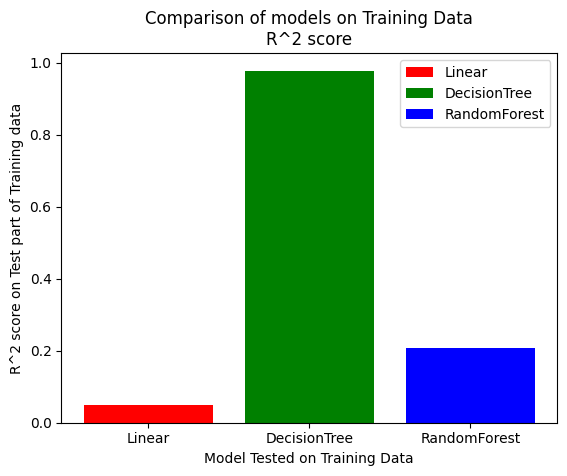

Best model is: DecisionTree with score: 0.9778572335603084


In [33]:
# plot score of each model on bar chart
def plotScore(modelNameList,models):
    modelscoresList = [x.score(Xtest,Ytest) for x in models]
    plt.bar(modelNameList, modelscoresList,color=['red','green','blue'],label=modelNameList)
    plt.title("Comparison of models on Training Data\nR^2 score")
    plt.xlabel("Model Tested on Training Data")
    plt.ylabel("R^2 score on Test part of Training data")
    plt.legend()
    plt.show()
    maxScore = max(modelscoresList)
    modelIndexWithMaxScore = modelscoresList.index(maxScore)
    print(f"Best model is: {modelNameList[modelIndexWithMaxScore]} with score: {maxScore}")

plotScore(["Linear","DecisionTree","RandomForest"],[AImodelLinear,AImodelDecision,AImodelForest])

<h3>Considering R^2 scores and training time we have selected Decision Tree Regression for our model</h3>

In [34]:
# make rolling window function
from sklearn.metrics import mean_absolute_error


def rollTheWindow(data,windowSize,AImodel,PrintResults=False):
    datasetLength = len(data)
    listOfPredictions = []
    numberOfWindows = datasetLength//windowSize
    index = 0
    lastWindow = False
    for i in range(numberOfWindows):
        rollingWindow = []
        lowerLimit = index
        upperLimit = index+windowSize
        if upperLimit > datasetLength:
            upperLimit = datasetLength-1
        if lowerLimit >= upperLimit:
            break
        rollingWindow.append(data[lowerLimit:upperLimit])
        rollingWindow = pd.concat(rollingWindow)
        X_WINDOW_INPUT = rollingWindow[['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5']]
        Y_WINDOW_OUTPUT = rollingWindow['supply_demand']
        currentPrediction = AImodel.predict(X_WINDOW_INPUT)
        meanSqError = mean_squared_error(Y_WINDOW_OUTPUT, currentPrediction)
        meanAbError = mean_absolute_error(Y_WINDOW_OUTPUT, currentPrediction)
        if PrintResults:
            print(f"Prediction for window [{lowerLimit},{upperLimit}] MSE={meanSqError} MAE={meanAbError}")
        predictionTuple = (lowerLimit,upperLimit,currentPrediction,meanSqError,Y_WINDOW_OUTPUT,meanAbError)
        listOfPredictions.append(predictionTuple)
        index = upperLimit + 1
        if index >= datasetLength-1 and lastWindow == False:
            lastWindow = True
            index = datasetLength-1
        elif index >= datasetLength-1 and lastWindow == True:
            break
    maxSqError= max(listOfPredictions, key=lambda item: item[3])
    minSqEror = min(listOfPredictions, key=lambda item: item[3])
    maxAbError= max(listOfPredictions, key=lambda item: item[5])
    minAbEror = min(listOfPredictions, key=lambda item: item[5])
    print(f"Max MSE={maxSqError[3]} MAE={maxAbError[5]}")
    print(f"Min MSE={minSqEror[3]} MAE={minAbEror[5]}")
    print("Average MSE ",np.mean([x[3] for x in listOfPredictions]))
    print("Average MAE ",np.mean([x[5] for x in listOfPredictions]))
    return listOfPredictions,maxSqError,minSqEror,maxAbError,minAbEror

Max MSE=2337.164 MAE=18.688
Min MSE=0.0 MAE=0.0
Average MSE  1.145273171914724
Average MAE  0.022841023838737592


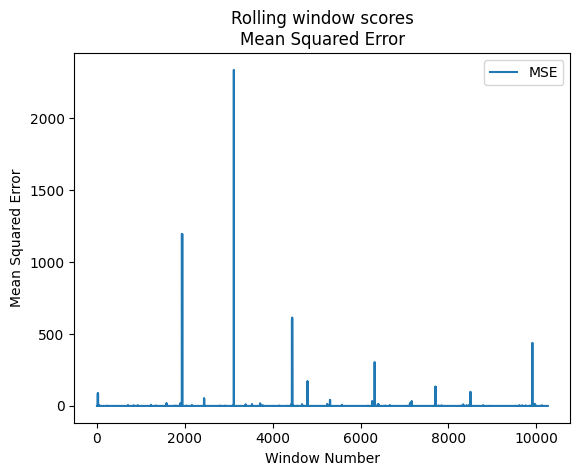

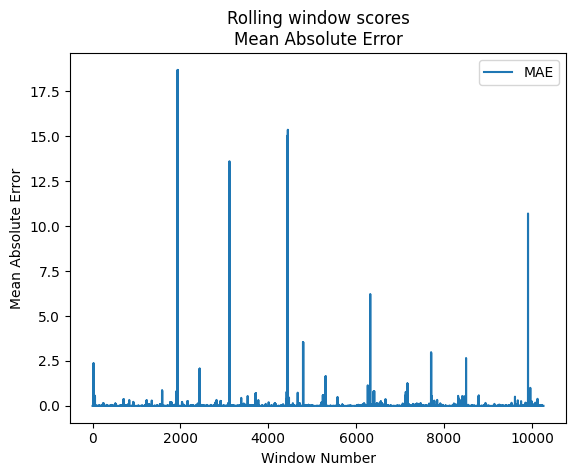

In [37]:
def plotMSE(listOfPredictions):
    MSElist =[x[3] for x in listOfPredictions] 
    plt.plot(MSElist,label="MSE")
    plt.title("Rolling window scores\nMean Squared Error")
    plt.xlabel("Window Number")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.show()
    return

def plotMAE(listOfPredictions):
    MAElist =[x[5] for x in listOfPredictions] 
    plt.plot(MAElist,label="MAE")
    plt.title("Rolling window scores\nMean Absolute Error")
    plt.xlabel("Window Number")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.show()
    return

def plotRollingScores(listOfPredictions):
    plotMSE(listOfPredictions)
    plotMAE(listOfPredictions)
    return
    
windowResult = rollTheWindow(orderData,1000,AImodelDecision)
plotRollingScores(windowResult[0])

<h1>Model Optimization</h1>

In [ ]:
# optimize model here using grid search

<h1 style="background-color:blue">Read Test Data</h1>

In [31]:
# read test data
# read region Data
regionTestData = pd.read_csv('./test_set/cluster_map/cluster_map', sep='\t', names=['region_hash', 'region_id'],dtype={'region_hash': 'str', 'region_id': 'int'})
print(regionTestData.head())
#regionData.to_csv('regionData.csv',index=False)

                        region_hash  region_id
0  90c5a34f06ac86aee0fd70e2adce7d8a          1
1  f2c8c4bb99e6377d21de71275afd6cd2          2
2  58c7a4888306d8ff3a641d1c0feccbe3          3
3  b26a240205c852804ff8758628c0a86a          4
4  4b9e4cf2fbdc8281b8a1f9f12b80ce4d          5


In [32]:
# read order data
dataTypes = {'order_id':'str', 'driver_id':'str','start_region_hash':'str', 'dest_region_hash':'str' ,'time':'str'}
orderDataPath = './test_set/order_data/'
orderTestData = readMultipleData(orderDataPath,'test_order', ['order_id', 'driver_id', 'start_region_hash','dest_region_hash','time'], dataTypes,delimiter2=",")
print("printing order data")
print(orderTestData.head())

5 files read
printing order data
                           order_id                         driver_id   
0  a903b5f7f65f1dc7f4ee94fec74673be  dce1e90fc91ed39a7b04a22d02910a7d  \
1  b7c838beaf12a2132776a1f00e016038  1f39eba5ce330f20c95177826a122e12   
2  0e0d3c93298ed59281352e34c6f1ec5a  8e4e2bc0342b3c55edea2723f6613e36   
3  1f6d0d7f68f216c4333969d6152a0a8b  5a33393e516673c8e9a065915667a30f   
4  bcf6050d9f5b270f8beb3ff80b01b435  f0232b8e45abc5ca92ca0f90fa811e7c   

                  start_region_hash                  dest_region_hash   
0  d4ec2125aff74eded207d2d915ef682f  d4ec2125aff74eded207d2d915ef682f  \
1  2407d482f0ffa22a947068f2551fe62c  2407d482f0ffa22a947068f2551fe62c   
2  b26a240205c852804ff8758628c0a86a  3a43dcdff3c0b66b1acb1644ff055f9d   
3  4725c39a5e5f4c188d382da3910b3f3f  4725c39a5e5f4c188d382da3910b3f3f   
4  dd8d3b9665536d6e05b29c2648c0e69a  a5609739c6b5c2719a3752327c5e33a7   

                  time  
0  2016-01-23 07:20:52  
1  2016-01-23 13:08:17  
2  2016-01-23 

In [33]:
# read weather data
dataTypes={'time':'str', 'weather':'int', 'temperature':'double', 'PM2.5':'double'}
weatherTestDataPath = './test_set/weather_data/'
weatherTestData = readMultipleData(weatherTestDataPath,'weather_data', ['time', 'weather', 'temperature', 'PM2.5'], dataTypes)
print("printing weather data")
print(weatherTestData.head())

5 files read
printing weather data
                  time  weather  temperature  PM2.5
0  2016-01-23 07:01:12        4          1.0   94.0
1  2016-01-23 11:14:04        3         -1.0  107.0
2  2016-01-23 13:16:44        3         -1.0   56.0
3  2016-01-23 15:02:02        3          0.0   48.0
4  2016-01-23 15:16:39        3          0.0   48.0


In [34]:
#pre processing weather Test Data based on weather timeSlot 
weatherTestData['time_slot'] = weatherTestData['time'].apply(calculateTimeSlot,printValue=False)
weatherTestData['date'] = weatherTestData['time'].apply(extractDate)
# weatherData['day_of_week'] = weatherData['time'].apply(extractDayOfWeek)
weatherTestData = weatherTestData.drop(['time'], axis=1)
print(weatherTestData.head())

   weather  temperature  PM2.5  time_slot        date
0        4          1.0   94.0         43  2016-01-23
1        3         -1.0  107.0         68  2016-01-23
2        3         -1.0   56.0         80  2016-01-23
3        3          0.0   48.0         91  2016-01-23
4        3          0.0   48.0         92  2016-01-23


In [35]:
orderTestData = pd.merge(regionTestData,orderTestData, how='inner', right_on='start_region_hash', left_on='region_hash')
print("Step 1 done")
orderTestData = orderTestData.rename(columns={'region_id': 'start_region_id'})
orderTestData = pd.merge(regionTestData,orderTestData, how='inner', right_on='dest_region_hash', left_on='region_hash')
orderTestData = orderTestData.rename(columns={'region_id': 'dest_region_id'})
print("Step 2 done")
orderTestData['time_slot'] = orderTestData['time'].apply(calculateTimeSlot,printValue=False)
print("Step 3 done")
orderTestData['day_of_week'] = orderTestData['time'].apply(extractDayOfWeek)
print("Step 4 done")
orderTestData['date'] = orderTestData['time'].apply(extractDate)
print("Step 5 done")
orderTestData = orderTestData.drop(['dest_region_hash','start_region_hash'], axis=1)
print("Step 6 done")
orderTestData['time_part'] = orderTestData['time'].apply(extractTime)
print(orderTestData.head())

Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  31bcca3b90b4d971697156b63900d514  172b54135139345fb9d24d0b23635387  \
1  cca7aca7134cffb46957d59897dcdbbc  773dd49e4148d807b099b42372fd5ac7   
2  85cbab6eaea4b6bf1bc2cd7ce6701a93  75eb

In [36]:
# read POI Data
poiDataStr = {
    'region_hash':[],
    'poi_class':[]
}
with open('./test_set/poi_data/poi_data','r') as fileToRead:
    for line in fileToRead:
        line = line.strip()
        columns = line.split('\t')
        poiDataStr['region_hash'].append(columns[0])
        remData = columns[1:]
        poiDataStr['poi_class'].append(remData)
        
poiTestData = pd.DataFrame(poiDataStr,columns=['region_hash','poi_class'])
poiTestData['poi_count'] = poiTestData['poi_class'].apply(extractNumberOfPOI)
poiTestData = pd.merge(regionTestData,poiTestData, how='inner', on='region_hash')
poiTestData = poiTestData.drop(['region_hash'], axis=1)
poiTestData = poiTestData.drop(['poi_class'], axis=1)
print(poiTestData.head())

   region_id  poi_count
0          1     653376
1          2     343537
2          3      31125
3          4     187829
4          5      27888


In [37]:
# print(mergedDataCSV)
orderTestData['requests'] = 1
# print(orderData.head())
groupedTestMergedData = orderTestData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['requests'].agg('sum').reset_index()
# groupedMergedData = groupedMergedData.drop(['date','region_hash','order_id','driver_id','time'], axis=1)
orderTestData = pd.merge(orderTestData,groupedTestMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id'])
print(orderTestData.head())

                      region_hash_x  dest_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a               1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a               1   
2  90c5a34f06ac86aee0fd70e2adce7d8a               1   
3  90c5a34f06ac86aee0fd70e2adce7d8a               1   
4  90c5a34f06ac86aee0fd70e2adce7d8a               1   

                      region_hash_y  start_region_id   
0  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  31bcca3b90b4d971697156b63900d514  172b54135139345fb9d24d0b23635387  \
1  cca7aca7134cffb46957d59897dcdbbc  773dd49e4148d807b099b42372fd5ac7   
2  85cbab6eaea4b6bf1bc2cd7ce6701a93  75eb96caaa6bacb30b810996d655dd54   
3  50f3588c595eca21e6be6182d521decc  c7b

In [38]:
orderTestData = orderTestData.drop(["requests_x"], axis=1)
orderTestData = orderTestData.drop(["region_hash_x"], axis=1)
orderTestData = orderTestData.rename(columns={"region_hash_y": "region_hash"})
orderTestData = orderTestData.rename(columns={"requests_y": "requests"})
print(orderTestData.head())

   dest_region_id                       region_hash  start_region_id   
0               1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4               1  90c5a34f06ac86aee0fd70e2adce7d8a                1   

                           order_id                         driver_id   
0  31bcca3b90b4d971697156b63900d514  172b54135139345fb9d24d0b23635387  \
1  cca7aca7134cffb46957d59897dcdbbc  773dd49e4148d807b099b42372fd5ac7   
2  85cbab6eaea4b6bf1bc2cd7ce6701a93  75eb96caaa6bacb30b810996d655dd54   
3  50f3588c595eca21e6be6182d521decc  c7bddad06fdf4fd7bb77c3007118d215   
4  3c751c264452c4d73e90dd6066566e94  54402bda533bb92ec3d697c361ca683d   

                  time  time_slot  day_of_week        date time_part  requests  
0  2016-01-23 19:09:39        116            5 

In [39]:
orderTestData['temp'] = 1
orderTestData['answers'] = orderTestData['temp'].where(orderTestData['driver_id'].notnull(), 0)
orderTestData = orderTestData.drop(['temp'], axis=1)
groupedTestMergedData = orderTestData.groupby(['start_region_id','time_slot','day_of_week','dest_region_id'])['answers'].agg('sum').reset_index()
orderTestData = pd.merge(orderTestData,groupedTestMergedData, how='left' , on=['start_region_id','time_slot','day_of_week','dest_region_id'])
print(orderTestData)

        dest_region_id                       region_hash  start_region_id   
0                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                ...                               ...              ...   
467906              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467907              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467908              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467909              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467910              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                order_id                         driver_id 

In [40]:
orderTestData = orderTestData.drop(["answers_x"], axis=1)
orderTestData = orderTestData.rename(columns={"answers_y": "answers"})
# orderTestData.to_csv('mergedOrderData.csv',index=False)

In [41]:
# orderTestData['supply_demand'] = orderTestData['requests'] - orderTestData['answers']
orderTestData['supply_demand'] = orderTestData['requests']
print(orderTestData)

        dest_region_id                       region_hash  start_region_id   
0                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1  \
1                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
2                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
3                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
4                    1  90c5a34f06ac86aee0fd70e2adce7d8a                1   
...                ...                               ...              ...   
467906              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467907              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467908              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467909              66  1ecbb52d73c522f184a6fc53128b1ea1               66   
467910              66  1ecbb52d73c522f184a6fc53128b1ea1               66   

                                order_id                         driver_id 

In [42]:
orderTestData = orderTestData.drop(['order_id','driver_id','requests','answers','region_hash','time'], axis=1)
print(orderTestData)

        dest_region_id  start_region_id  time_slot  day_of_week        date   
0                    1                1        116            5  2016-01-23  \
1                    1                1        127            5  2016-01-23   
2                    1                1         43            5  2016-01-23   
3                    1                1         81            5  2016-01-23   
4                    1                1         93            5  2016-01-23   
...                ...              ...        ...          ...         ...   
467906              66               66         69            6  2016-01-31   
467907              66               66        104            6  2016-01-31   
467908              66               66        103            6  2016-01-31   
467909              66               66         57            6  2016-01-31   
467910              66               66         92            6  2016-01-31   

       time_part  supply_demand  
0       19:09:39 

In [43]:
orderTestData = pd.merge(orderTestData,poiData, how="inner", left_on='start_region_id', right_on='region_id')
orderTestData = orderTestData.rename(columns={"poi_count": "start_poi_count"})
orderTestData = pd.merge(orderTestData,poiData, how="inner", left_on='dest_region_id',right_on='region_id')
orderTestData = orderTestData.rename(columns={"poi_count": "dest_poi_count"})
orderTestData = orderTestData.drop(['region_id_x','region_id_y'], axis=1)
print(orderTestData)

        dest_region_id  start_region_id  time_slot  day_of_week        date   
0                    1                1        116            5  2016-01-23  \
1                    1                1        127            5  2016-01-23   
2                    1                1         43            5  2016-01-23   
3                    1                1         81            5  2016-01-23   
4                    1                1         93            5  2016-01-23   
...                ...              ...        ...          ...         ...   
467906              63               63         79            2  2016-01-27   
467907              63               63         56            2  2016-01-27   
467908              63               63         68            4  2016-01-29   
467909              63               63         68            4  2016-01-29   
467910              63               63         57            4  2016-01-29   

       time_part  supply_demand  start_poi_count  d

In [44]:
orderTestData = pd.merge(weatherTestData,orderTestData, how="inner", on=['date','time_slot'])
print(orderTestData)


        weather  temperature  PM2.5  time_slot        date  dest_region_id   
0             4          1.0   94.0         43  2016-01-23               1  \
1             4          1.0   94.0         43  2016-01-23               1   
2             4          1.0   94.0         43  2016-01-23               1   
3             4          1.0   94.0         43  2016-01-23               1   
4             4          1.0   94.0         43  2016-01-23               1   
...         ...          ...    ...        ...         ...             ...   
288877        8          1.0   69.0        141  2016-01-31              49   
288878        8          1.0   69.0        141  2016-01-31              64   
288879        8          1.0   69.0        141  2016-01-31              64   
288880        8          1.0   69.0        141  2016-01-31              32   
288881        8          1.0   69.0        141  2016-01-31              17   

        start_region_id  day_of_week time_part  supply_demand  

In [45]:
# mTest = orderTestData.drop_duplicates(keep='first')
mTest = orderTestData.copy()
mTest = mTest.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['supply_demand'].agg('mean').reset_index()
# mTest = mTest.drop_duplicates(subset=['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'],keep='first')
print(mTest)

       start_region_id  time_slot  day_of_week  dest_region_id   
0                    1         43            2               1  \
1                    1         43            2               8   
2                    1         43            2              21   
3                    1         43            2              36   
4                    1         43            2              42   
...                ...        ...          ...             ...   
34127               66        141            0              66   
34128               66        141            2              66   
34129               66        141            4              66   
34130               66        141            5              66   
34131               66        141            6              66   

       start_poi_count  dest_poi_count  weather  temperature  PM2.5   
0               653376          653376        3          3.0   76.0  \
1               653376         1518402        3          3.0   76

<h1 style="background-color:skyblue; color:black">Prediction on Test Data</h1>

In [46]:
# XTest = mTest[['region_id','time_slot','day_of_week','weather','poi_count']]
# YTest = mTest['supply_demand']
# print("accuracy: ",AImodel.score(XTest,YTest))
# print(YTest)

In [47]:
listOfPredictions =  rollTheWindow(mTest,100)
maxSqError= max(listOfPredictions, key=lambda x: x[3])
minSqEror = min(listOfPredictions, key=lambda x: x[3])
maxAbError= max(listOfPredictions, key=lambda x: x[5])
minAbEror = min(listOfPredictions, key=lambda x: x[5])
print("-------------------------------------------------------")
print(f"Max MSE={maxSqError[3]} MAE={maxAbError[5]}")
print(f"Min MSE={minSqEror[3]} MAE={minAbEror[5]}")
# print(f"Total MSE={} MAE={}")

Prediction for window [0,100] MSE=750.23 MAE=11.13
Prediction for window [101,201] MSE=745.3 MAE=11.46
Prediction for window [202,302] MSE=688.61 MAE=10.73
Prediction for window [303,403] MSE=942.17 MAE=13.11
Prediction for window [404,504] MSE=1618.55 MAE=16.57
Prediction for window [505,605] MSE=1365.45 MAE=15.15
Prediction for window [606,706] MSE=1146.05 MAE=14.79
Prediction for window [707,807] MSE=334.44 MAE=8.3
Prediction for window [808,908] MSE=115.22 MAE=6.18
Prediction for window [909,1009] MSE=133.71 MAE=9.71
Prediction for window [1010,1110] MSE=21.6 MAE=3.08
Prediction for window [1111,1211] MSE=3.96 MAE=1.38
Prediction for window [1212,1312] MSE=46.88 MAE=4.16
Prediction for window [1313,1413] MSE=10.59 MAE=2.45
Prediction for window [1414,1514] MSE=13.21 MAE=2.47
Prediction for window [1515,1615] MSE=17.09 MAE=2.63
Prediction for window [1616,1716] MSE=44.95 MAE=3.75
Prediction for window [1717,1817] MSE=65.25 MAE=4.65
Prediction for window [1818,1918] MSE=39.87 MAE=3.6

In [48]:
# print mean of mean squared error
errors = [x[3] for x in listOfPredictions]
print("Mean of mean squared error for above predictions is: ",np.mean(errors))
print("Min error: ",np.min(errors))
print("Max error: ",np.max(errors))

Mean of mean squared error for above predictions is:  234.11998803978344
Min error:  1.59
Max error:  2018.9


In [49]:
Xtest = mTest[['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5']]
Ytest = mTest['supply_demand']
print("Accuracy of the model is: ",AImodel.score(Xtest,Ytest))

Accuracy of the model is:  0.5048113177900492


<h1 style="background-color:orange; color:black">Plot actual gap and predicted gap against time</h1>

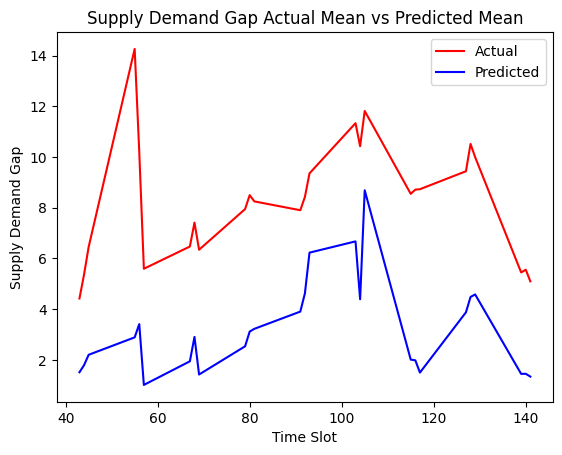

In [50]:
fXTest = mTest.copy()
fYTest = fXTest['supply_demand']
fXTest['predicted'] = AImodel.predict(fXTest[['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5']])
groupedfXTestSupply = fXTest.groupby(['time_slot'])['supply_demand'].agg('mean').reset_index()
groupedfXTestPredicted = fXTest.groupby(['time_slot'])['predicted'].agg('mean').reset_index()

plt.plot(groupedfXTestSupply['time_slot'],groupedfXTestSupply['supply_demand'],label='Actual',color='red')
plt.plot(groupedfXTestPredicted['time_slot'],groupedfXTestPredicted['predicted'],label='Predicted',color='blue')
plt.xlabel('Time Slot')
plt.ylabel('Supply Demand Gap')
plt.title('Supply Demand Gap Actual Mean vs Predicted Mean')
plt.legend()

<h1>Actual Values and Mean Predicted Values against rows(index)</h1>

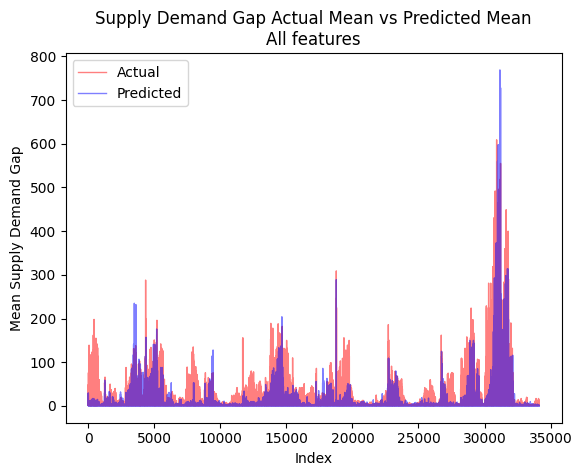

In [51]:
zXTest = mTest.copy()
zYTest = zXTest['supply_demand']
zXTest['predicted'] = AImodel.predict(zXTest[['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5']])
# plotting the actual values and the mean predicted values

#groupedzXTestSupply = zXTest.groupby(['time_slot'])['supply_demand'].agg('mean').reset_index()
groupedzXTestSupply = zXTest.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['supply_demand'].agg('mean').reset_index()
groupedzXTestPredicted = zXTest.groupby(['start_region_id','time_slot','day_of_week','dest_region_id','start_poi_count','dest_poi_count','weather','temperature','PM2.5'])['predicted'].agg('mean').reset_index()

xRange = range(0,groupedzXTestSupply.shape[0])
plt.plot(xRange,groupedzXTestSupply['supply_demand'],label='Actual',color='red',alpha=0.5,linewidth=1)
plt.plot(xRange,groupedzXTestPredicted['predicted'],label='Predicted',color='blue',alpha=0.5,linewidth=1)
plt.xlabel('Index')
plt.ylabel('Mean Supply Demand Gap')
plt.title('Supply Demand Gap Actual Mean vs Predicted Mean\nAll features')
plt.legend()
plt.show()